In [21]:
import pandas as pd
import re
import seaborn as sns
import pymorphy2
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import numpy as np
import spacy
from pymorphy2 import MorphAnalyzer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import LSTM, Dropout, Dense, Flatten,Bidirectional
from keras.activations import elu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
import warnings
import emoji
warnings.filterwarnings("ignore")



In [22]:

# Загрузка данных
df = pd.read_csv("cource.csv")

# Загрузка и объединение стоп-слов
nltk.download('stopwords')
russian_stop_words = set(stopwords.words('russian'))
english_stop_words = set(stopwords.words('english'))
stop_words = russian_stop_words.union(english_stop_words)

# Инициализация морфологического анализатора
morph = MorphAnalyzer()

# Функция для преобразования эмодзи в текст
def convert_emoji_to_text(text):
    return emoji.demojize(text, language='en')

# Функция для удаления стоп-слов
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Функция очистки текста
def clean_text(text):
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    text = re.sub(r'[\"\'«»“”„‟‘’‛❛❜❝❞❮❯❙❚:_-]+', '', text)
    text = re.sub(r'[!?\(\)\[\]{}]', '', text)
    text = re.sub(r'[\r\n\t]+', ' ', text)  # замена на пробел для избежания словослияний
    text = re.sub(r'[\x00-\x1F\x7F]+', '', text)
    text = re.sub(r'\d+', '', text)  # удаление чисел
    text = text.lower()
    text = text.strip()
    return text

# Применение функций обработки
df['text'] = df['text'].apply(lambda x: str(x))
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(convert_emoji_to_text)

# Удаление дубликатов и пропущенных значений
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Сохранение очищенных данных
df.to_csv("clean_cource.csv", index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgenijselisev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
df

,target,text
0,zd,
1,zd,трансмашхолдинг представил программу развития ...
3,zd,последние годы транспорт рф достиг значимых ре...
4,zd,аккумуляторы источники резервного питания тонн...
5,zd,зубчатая железная дорога dolderbahn швейцарии ...
...,...,...
4763,voda,электроэнергию белаэс будут поставлять российс...
4764,voda,навигацию года предприятия водного транспорта ...
4765,voda,новые контейнерные линии прорабатываются санкт...
4766,voda,ростовской области году планируется запустить ...


In [24]:
df.shape

(3146, 2)

In [25]:
m_texts = df[df['target'] == 'moskva']['text']
m_texts


2890                                                     
2891    давайте вместе радоваться весне всем берёзовог...
2893    камеры дорогах москвы помогают контролировать ...
2894    :movie_camera: видели наш совместный проект мо...
2900    :railway_track: рискуйте своим здоровьем — соб...
                              ...                        
3985    послание президента россии владимира владимиро...
3988    :microphone: сюрпризов ко дню рождения бкл пло...
3993    готовы встретить весну вместе нами рассказывае...
3994    :snowflake: зиму работал бесплатный каток глав...
3995                                                  nan
Name: text, Length: 393, dtype: object

In [26]:
zd_texts = df[df['target'] == 'zd']['text']
zd_texts

0                                                        
1       трансмашхолдинг представил программу развития ...
3       последние годы транспорт рф достиг значимых ре...
4       аккумуляторы источники резервного питания тонн...
5       зубчатая железная дорога dolderbahn швейцарии ...
                              ...                        
2885    db довольны первым электропоездом аккумуляторн...
2886    pkp intercity получит модернизированных пассаж...
2887    rail baltica план закупок млрд евро году коорд...
2888    минтранс вводит информационную систему электро...
2889                                                  nan
Name: text, Length: 2437, dtype: object

In [27]:
v_texts = df[df['target'] == 'voda']['text']
v_texts

3996                                                     
3997    новый речной форум торговопромышленной палаты ...
3998    приглашаем лекцию история отечественного парох...
4001    четверг, марта г. школьники студенты регионов ...
4002    sitronics group бф система расскажут школьника...
                              ...                        
4763    электроэнергию белаэс будут поставлять российс...
4764    навигацию года предприятия водного транспорта ...
4765    новые контейнерные линии прорабатываются санкт...
4766    ростовской области году планируется запустить ...
4767    столичные причалы начали готовить открытию нав...
Name: text, Length: 316, dtype: object

In [28]:
# Сколько различных слов в нашем массиве
results = set()
df['text'].str.lower().str.split().apply(results.update)
print('Количество слов в массиве с обращениями', len(results))

Количество слов в массиве с обращениями 41340


In [29]:
df['target'].value_counts()

target
zd        2437
moskva     393
voda       316
Name: count, dtype: int64

In [30]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download ru_core_news_lg


In [31]:

nlp_en = spacy.load('en_core_web_sm')
nlp_ru = spacy.load('ru_core_news_lg')  

morph = pymorphy2.MorphAnalyzer()

def tokenize_and_lemmatize(text):

    if re.search('[а-яА-Я]', text):
        doc = nlp_ru(text)
    else:
        doc = nlp_en(text)
    
  
    lemmatized_tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
    return lemmatized_tokens


df['tokens'] = df['text'].apply(tokenize_and_lemmatize)


word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=10, min_count=2, workers=5, sg=1)

def text_to_vector(text):

    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)


df['text_vectors'] = df['tokens'].apply(text_to_vector)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['text_vectors'], df['target'], test_size=0.5, random_state=42, shuffle = True)


X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# RNN

In [33]:
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  
    else:
        return lr * K.exp(-0.1)


model = Sequential([
    Bidirectional(LSTM(512, input_shape=(X_train.shape[1], 1), return_sequences=True)),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    Dropout(0.2), 
    Flatten(),
    Dense(512, activation=elu, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(256, activation=elu, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


initial_learning_rate = 0.001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=initial_learning_rate, epsilon=1e-08),
    metrics=['accuracy']
)

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
history = model.fit(
    X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train_encoded,
    epochs=69, batch_size=32, validation_split=0.5,
    callbacks=[lr_scheduler_callback]
)
test_loss, test_acc = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_encoded)
print('Test Accuracy:', test_acc)


Epoch 1/69
25/25 [==============================] - 36s 1s/step - loss: 1.2535 - accuracy: 0.8486 - val_loss: 0.8359 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 2/69
25/25 [==============================] - 30s 1s/step - loss: 0.6718 - accuracy: 0.9224 - val_loss: 0.6002 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 3/69
25/25 [==============================] - 30s 1s/step - loss: 0.5129 - accuracy: 0.9313 - val_loss: 0.4444 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 4/69
25/25 [==============================] - 30s 1s/step - loss: 0.4515 - accuracy: 0.9402 - val_loss: 0.4608 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 5/69
25/25 [==============================] - 30s 1s/step - loss: 0.4395 - accuracy: 0.9275 - val_loss: 0.4015 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 6/69
25/25 [==============================] - 30s 1s/step - loss: 0.4224 - accuracy: 0.9351 - val_loss: 0.4506 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 7/69
25/25 [==============================] - 34s 1s/step - loss: 0.3890 - a

Точность на тестовом наборе данных: 0.9631277918815613


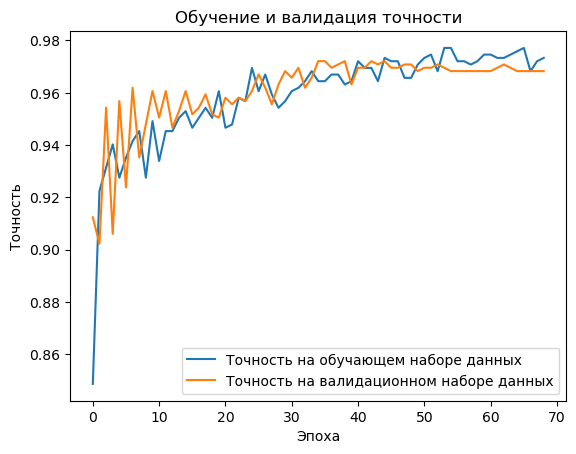

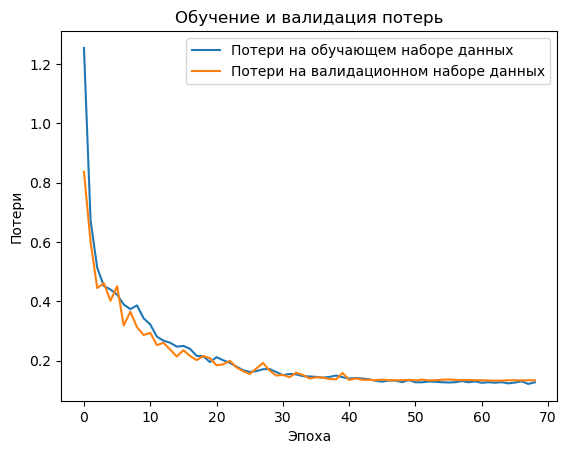

In [41]:
# Оценка точности теста
test_loss, test_acc = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_encoded, verbose=0)
print('Точность на тестовом наборе данных:', test_acc)


plt.plot(history.history['accuracy'], label='Точность на обучающем наборе данных')
plt.plot(history.history['val_accuracy'], label='Точность на валидационном наборе данных')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Обучение и валидация точности')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Потери на обучающем наборе данных')
plt.plot(history.history['val_loss'], label='Потери на валидационном наборе данных')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Обучение и валидация потерь')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score


y_pred_proba = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))


y_pred = np.argmax(y_pred_proba, axis=1)


roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
precision = precision_score(y_test_encoded, y_pred, average='weighted')

print('ROC-AUC:', roc_auc)
print('F1-score:', f1)
print('Recall:', recall)
print('Precision:', precision)


50/50 [==============================] - 16s 314ms/step
ROC-AUC: 0.9927454976769426
F1-score: 0.9625131060753827
Recall: 0.9631277813095995
Precision: 0.9630580584361585


50/50 [==============================] - 15s 305ms/step


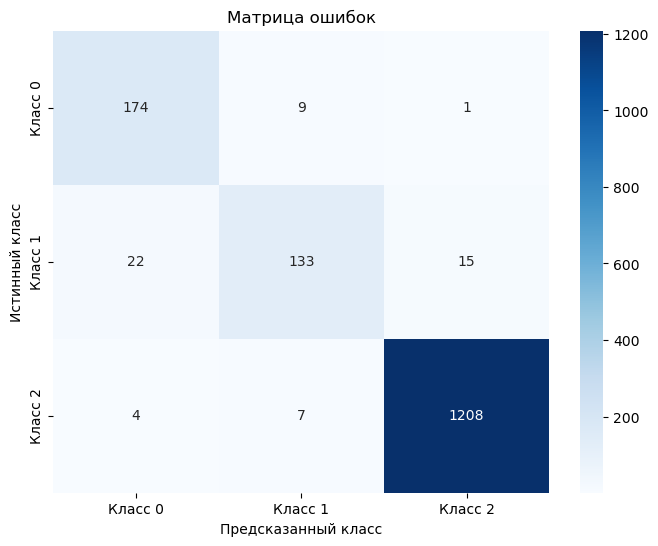

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Предсказание меток классов для тестовых данных
y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
y_pred = np.argmax(y_pred, axis=1)

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Класс 0', 'Класс 1', 'Класс 2'], 
            yticklabels=['Класс 0', 'Класс 1', 'Класс 2'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


In [44]:

class_labels = label_encoder.classes_


for index, label in enumerate(class_labels):
    print(f"Class {index} corresponds to target '{label}'")


Class 0 corresponds to target 'moskva'
Class 1 corresponds to target 'voda'
Class 2 corresponds to target 'zd'


# CatBoost

In [45]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix



model_catboost = CatBoostClassifier(auto_class_weights='Balanced',loss_function='MultiClass', verbose=0)
model_catboost.fit(X_train.reshape(X_train.shape[0], -1), y_train_encoded)


y_pred_probabilities_catboost = model_catboost.predict_proba(X_test.reshape(X_test.shape[0], -1))


y_pred_catboost = np.argmax(y_pred_probabilities_catboost, axis=1)


roc_auc = roc_auc_score(y_test_encoded, y_pred_probabilities_catboost, multi_class='ovo')
f1 = f1_score(y_test_encoded, y_pred_catboost, average='weighted')

print('ROC AUC:', roc_auc)
print('F1 Score:', f1)



ROC AUC: 0.9880476700256734
F1 Score: 0.9629637649634145


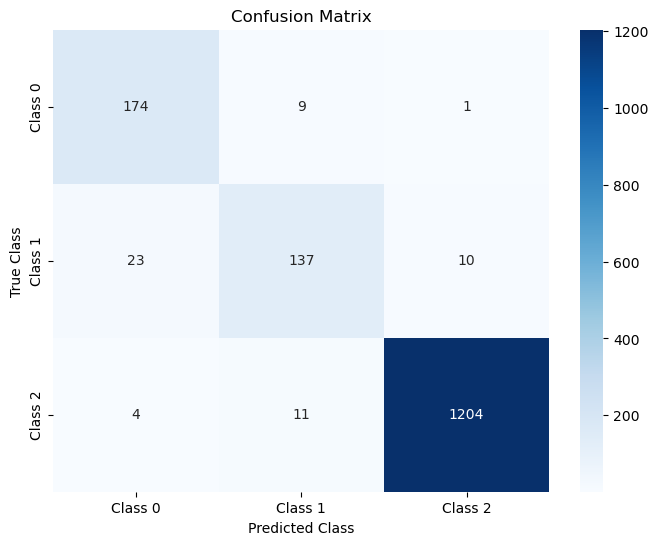

In [46]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_catboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


In [47]:
def preprocess_new_text(text):
    
    text = clean_text(text)
    text = remove_stopwords(text)
    text = convert_emoji_to_text(text)
    tokens = tokenize_and_lemmatize(text)
  
    text_vector = text_to_vector(tokens)
    return np.array([text_vector]) 

new_post_text = '''Московские власти приобрел новое скоростное судно.'''


preprocessed_new_post = preprocess_new_text(new_post_text)


predicted_class_probs = model.predict(preprocessed_new_post.reshape(preprocessed_new_post.shape[0], preprocessed_new_post.shape[1], 1))
predicted_class_index = np.argmax(predicted_class_probs)
predicted_class = label_encoder.classes_[predicted_class_index]

print("Новый пост отнесен к категории номер:", predicted_class)


1/1 [==============================] - 0s 95ms/step
Новый пост отнесен к категории номер: voda
